In [1]:
import torchtext
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn.functional as F
from torchtext import data
from torch import nn
import random

import spacy
import math

import sys
sys.path.append('..')

from utils.load_data import GLOVE_PATH, LABEL_TO_INT

In [2]:
outpath = '/home/ndg/users/jkurre/mnli/models/bilstm.pt'

In [3]:
LABEL_TO_INT

{'contradiction': 1, 'entailment': 2, 'neutral': 3}

### Load Dataset

In [4]:
source = data.Field(
        tokenize = 'spacy'
        # , lower = True
        , batch_first = True
)

target = data.Field(
        sequential=False
        , use_vocab = False
        , is_target=True
)

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = '/home/ndg/users/jkurre/mnli/utils'
    , train = 'train.csv'
    , validation = 'val.csv'
    , test = 'test.csv'
    , format = 'csv'
    , fields = {'sentence': ('text', source), 'gold_label': ('target', target)}
)

source.build_vocab(train_data, min_freq=2)
source.vocab.load_vectors(torchtext.vocab.Vectors(GLOVE_PATH, cache="."))

print(source.vocab.vectors.shape)
print(f"Unique tokens in text vocabulary: {len(source.vocab)}")

torch.Size([86080, 50])
Unique tokens in text vocabulary: 86080


### Build Model

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 4, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.reshape((1, hidden.shape[1], hidden.shape[2] * 2))
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        catted = torch.cat([hidden, encoder_outputs], 2)
        energy = F.relu(self.attn(catted))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]
    
class Seq2One(nn.Module):
    def __init__(self, input_size, output_size, embed_size,
                 hidden_size, n_layers, dropout):
        
        super(Seq2One, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.dropout = nn.Dropout(dropout)
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers, dropout=dropout, 
                            bidirectional=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(self.hidden_size * 2, output_size)
        
    def forward(self, x):
        # x: (seq_length, N) where N is the batch size
        embedded = self.dropout(self.embed(x.transpose(0,1)))
        # embedded: (seq_length, N, embed_size)
        outputs, (hidden, cell) = self.lstm(embedded)
        
        weights = self.attention(hidden[-2:], outputs)
        
        context = weights.bmm(outputs.transpose(0, 1))
        context = context.transpose(0, 1)
        
        context = context.squeeze(0)
        output = self.fc(context)
        output = F.log_softmax(output, dim=1)
        
        return output

In [6]:
"""Hyperparameters"""
# training
num_epochs = 20
learning_rate = 0.001
batch_size = 64

# model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(source.vocab)
output_size = len(LABEL_TO_INT)
embed_size = 50
hidden_size = 1024 # 2014 benchmark; slightly small
num_layers = 2 # benchmark did 4
dropout = 0.5

# define iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = batch_size,
     sort_within_batch = True,
     sort_key = lambda x: len(x.text), # minimize padding
     device = device)


model = Seq2One(input_size, output_size, embed_size, hidden_size,
                  num_layers, dropout).to(device)

pad_idx = source.vocab.stoi["<pad"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# simple cross entropy cost (might be numerically unstable if pred has 0)
# https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/6
def xentropy_cost(x_target, log_x_pred):
    """Cross Entropy for One Hot Encoded Targets"""
    assert x_target.size() == log_x_pred.size(), "size fail ! " + str(x_target.size()) + " " + str(log_x_pred.size())
    return -torch.sum(x_target * log_x_pred)

In [7]:
xloss_values = []
loss_values = []
running_loss = 0.0

for epoch in range(num_epochs):
    
    print(f"Epoch {epoch} of {num_epochs}")
    
    for batch_idx, batch in enumerate(train_iterator):
        input_data = batch.text.to(device)
        target_data = batch.target.to(device)
        target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))
        # index values of shape (*) returns tensor of shape (*, num_classes)
        # encoding position corresponds to labels; subtract tensor by 1
        
        output = model(input_data)
        
        optimizer.zero_grad()
        loss = xentropy_cost(target_data_one_hot, output)
        
        if batch_idx % 10 == 9:
            print("XEntropy Loss:", round(loss.item(),2))
        
        # address gradient issue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        running_loss =+ loss.item() * batch_size
        xloss_values.append(loss.item())
    
    loss_values.append(running_loss)

Epoch 0 of 20
XEntropy Loss: 69.95
XEntropy Loss: 71.36
XEntropy Loss: 69.57
XEntropy Loss: 70.8
XEntropy Loss: 70.03
XEntropy Loss: 69.57
XEntropy Loss: 70.36
XEntropy Loss: 70.39
XEntropy Loss: 70.23
XEntropy Loss: 70.69
XEntropy Loss: 70.43
XEntropy Loss: 70.9
XEntropy Loss: 69.74
XEntropy Loss: 70.27
XEntropy Loss: 71.81
XEntropy Loss: 68.56
XEntropy Loss: 70.8
XEntropy Loss: 70.04
XEntropy Loss: 69.43
XEntropy Loss: 69.69
XEntropy Loss: 70.2
XEntropy Loss: 71.49
XEntropy Loss: 70.47
XEntropy Loss: 70.43
XEntropy Loss: 69.41
XEntropy Loss: 71.51
XEntropy Loss: 70.59
XEntropy Loss: 70.37
XEntropy Loss: 71.86
XEntropy Loss: 71.14
XEntropy Loss: 70.99
XEntropy Loss: 71.43
XEntropy Loss: 70.25
XEntropy Loss: 69.64
XEntropy Loss: 70.22
XEntropy Loss: 70.26
XEntropy Loss: 70.2
XEntropy Loss: 70.54
XEntropy Loss: 69.65
XEntropy Loss: 70.42
XEntropy Loss: 70.1
XEntropy Loss: 70.27
XEntropy Loss: 70.77
XEntropy Loss: 70.04
XEntropy Loss: 70.24
XEntropy Loss: 70.33
XEntropy Loss: 69.29
XEntr

XEntropy Loss: 70.74
XEntropy Loss: 69.89
XEntropy Loss: 68.71
XEntropy Loss: 70.65
XEntropy Loss: 70.97
XEntropy Loss: 70.69
XEntropy Loss: 70.42
XEntropy Loss: 70.26
XEntropy Loss: 70.5
XEntropy Loss: 70.37
XEntropy Loss: 69.61
XEntropy Loss: 70.5
XEntropy Loss: 70.74
XEntropy Loss: 69.68
XEntropy Loss: 71.65
XEntropy Loss: 70.55
XEntropy Loss: 71.07
XEntropy Loss: 71.05
XEntropy Loss: 70.34
XEntropy Loss: 70.39
XEntropy Loss: 70.55
XEntropy Loss: 71.08
XEntropy Loss: 70.66
XEntropy Loss: 70.52
XEntropy Loss: 72.3
XEntropy Loss: 70.47
XEntropy Loss: 70.66
XEntropy Loss: 70.25
XEntropy Loss: 70.1
XEntropy Loss: 70.59
XEntropy Loss: 70.42
XEntropy Loss: 70.03
XEntropy Loss: 69.43
XEntropy Loss: 68.66
XEntropy Loss: 70.72
XEntropy Loss: 70.49
XEntropy Loss: 70.55
XEntropy Loss: 70.72
XEntropy Loss: 70.59
XEntropy Loss: 70.37
XEntropy Loss: 71.85
XEntropy Loss: 70.29
XEntropy Loss: 70.17
XEntropy Loss: 70.69
XEntropy Loss: 70.11
XEntropy Loss: 70.28
XEntropy Loss: 70.6
XEntropy Loss: 70.

XEntropy Loss: 70.83
XEntropy Loss: 70.46
XEntropy Loss: 71.7
XEntropy Loss: 71.02
XEntropy Loss: 69.1
XEntropy Loss: 71.9
XEntropy Loss: 68.55
XEntropy Loss: 70.22
XEntropy Loss: 70.1
XEntropy Loss: 70.93
XEntropy Loss: 70.19
XEntropy Loss: 70.85
XEntropy Loss: 71.17
XEntropy Loss: 70.05
XEntropy Loss: 72.76
XEntropy Loss: 70.41
XEntropy Loss: 70.87
XEntropy Loss: 71.01
XEntropy Loss: 71.24
XEntropy Loss: 69.67
XEntropy Loss: 70.04
XEntropy Loss: 71.06
XEntropy Loss: 70.73
XEntropy Loss: 71.44
XEntropy Loss: 71.49
XEntropy Loss: 69.65
XEntropy Loss: 69.0
XEntropy Loss: 70.55
XEntropy Loss: 70.39
XEntropy Loss: 70.64
XEntropy Loss: 70.76
XEntropy Loss: 69.9
XEntropy Loss: 70.52
XEntropy Loss: 70.63
XEntropy Loss: 70.41
XEntropy Loss: 72.64
XEntropy Loss: 69.47
XEntropy Loss: 70.36
XEntropy Loss: 70.46
XEntropy Loss: 70.48
XEntropy Loss: 69.3
XEntropy Loss: 71.1
XEntropy Loss: 70.45
XEntropy Loss: 71.33
XEntropy Loss: 69.58
XEntropy Loss: 70.36
XEntropy Loss: 70.39
XEntropy Loss: 71.93


XEntropy Loss: 70.61
XEntropy Loss: 70.22
XEntropy Loss: 70.51
XEntropy Loss: 69.97
XEntropy Loss: 69.76
XEntropy Loss: 72.11
XEntropy Loss: 71.04
XEntropy Loss: 70.44
XEntropy Loss: 66.09
XEntropy Loss: 70.23
XEntropy Loss: 69.54
XEntropy Loss: 70.19
XEntropy Loss: 70.87
XEntropy Loss: 71.31
XEntropy Loss: 70.4
XEntropy Loss: 66.38
XEntropy Loss: 70.7
XEntropy Loss: 71.22
XEntropy Loss: 69.95
XEntropy Loss: 72.67
XEntropy Loss: 70.31
XEntropy Loss: 69.84
XEntropy Loss: 68.91
XEntropy Loss: 71.15
XEntropy Loss: 70.59
XEntropy Loss: 70.98
XEntropy Loss: 70.61
XEntropy Loss: 70.47
XEntropy Loss: 69.89
XEntropy Loss: 70.75
XEntropy Loss: 72.78
XEntropy Loss: 71.08
XEntropy Loss: 69.86
XEntropy Loss: 70.7
XEntropy Loss: 69.99
XEntropy Loss: 71.07
XEntropy Loss: 70.89
XEntropy Loss: 71.31
XEntropy Loss: 71.52
XEntropy Loss: 70.33
XEntropy Loss: 70.02
XEntropy Loss: 71.23
XEntropy Loss: 70.56
XEntropy Loss: 69.88
XEntropy Loss: 71.69
XEntropy Loss: 71.75
XEntropy Loss: 69.81
XEntropy Loss: 7

XEntropy Loss: 70.15
XEntropy Loss: 69.88
XEntropy Loss: 70.27
XEntropy Loss: 70.51
XEntropy Loss: 71.44
XEntropy Loss: 71.15
XEntropy Loss: 69.82
XEntropy Loss: 70.12
XEntropy Loss: 67.53
XEntropy Loss: 70.43
XEntropy Loss: 70.49
XEntropy Loss: 69.64
XEntropy Loss: 70.77
XEntropy Loss: 70.25
XEntropy Loss: 71.89
XEntropy Loss: 69.57
XEntropy Loss: 70.34
XEntropy Loss: 70.44
XEntropy Loss: 69.98
XEntropy Loss: 69.92
XEntropy Loss: 69.96
XEntropy Loss: 68.67
XEntropy Loss: 69.82
XEntropy Loss: 70.0
XEntropy Loss: 71.01
XEntropy Loss: 69.72
XEntropy Loss: 71.18
XEntropy Loss: 64.68
XEntropy Loss: 70.23
XEntropy Loss: 68.34
XEntropy Loss: 70.4
XEntropy Loss: 69.71
XEntropy Loss: 71.11
XEntropy Loss: 71.23
XEntropy Loss: 71.34
XEntropy Loss: 69.53
XEntropy Loss: 69.2
XEntropy Loss: 70.1
XEntropy Loss: 72.67
XEntropy Loss: 70.22
XEntropy Loss: 69.72
XEntropy Loss: 69.78
XEntropy Loss: 70.83
XEntropy Loss: 70.54
XEntropy Loss: 71.32
XEntropy Loss: 70.79
XEntropy Loss: 70.4
XEntropy Loss: 70.

XEntropy Loss: 72.01
XEntropy Loss: 68.92
XEntropy Loss: 71.84
XEntropy Loss: 70.19
XEntropy Loss: 69.73
XEntropy Loss: 71.24
XEntropy Loss: 70.1
XEntropy Loss: 69.14
XEntropy Loss: 66.89
XEntropy Loss: 70.0
XEntropy Loss: 70.02
XEntropy Loss: 72.78
XEntropy Loss: 72.53
XEntropy Loss: 70.55
XEntropy Loss: 72.08
XEntropy Loss: 70.26
XEntropy Loss: 68.69
XEntropy Loss: 69.3
XEntropy Loss: 69.95
XEntropy Loss: 70.86
XEntropy Loss: 68.24
XEntropy Loss: 70.26
XEntropy Loss: 70.31
XEntropy Loss: 72.77
XEntropy Loss: 66.96
XEntropy Loss: 70.7
XEntropy Loss: 72.94
XEntropy Loss: 70.55
XEntropy Loss: 70.88
XEntropy Loss: 69.86
XEntropy Loss: 69.67
XEntropy Loss: 69.99
XEntropy Loss: 65.59
XEntropy Loss: 70.6
XEntropy Loss: 65.27
XEntropy Loss: 69.65
XEntropy Loss: 67.31
XEntropy Loss: 71.87
XEntropy Loss: 69.28
XEntropy Loss: 71.13
XEntropy Loss: 69.71
XEntropy Loss: 70.89
XEntropy Loss: 69.52
XEntropy Loss: 72.75
XEntropy Loss: 69.04
XEntropy Loss: 69.55
XEntropy Loss: 69.04
XEntropy Loss: 70.

XEntropy Loss: 66.55
XEntropy Loss: 69.24
XEntropy Loss: 74.57
XEntropy Loss: 64.87
XEntropy Loss: 65.66
XEntropy Loss: 70.93
XEntropy Loss: 64.69
XEntropy Loss: 64.82
XEntropy Loss: 65.16
XEntropy Loss: 65.82
XEntropy Loss: 68.11
XEntropy Loss: 70.22
XEntropy Loss: 62.27
XEntropy Loss: 68.47
XEntropy Loss: 65.76
XEntropy Loss: 66.02
XEntropy Loss: 59.53
XEntropy Loss: 70.37
XEntropy Loss: 61.33
XEntropy Loss: 61.35
XEntropy Loss: 71.71
XEntropy Loss: 67.36
XEntropy Loss: 66.39
XEntropy Loss: 65.02
XEntropy Loss: 63.08
XEntropy Loss: 74.25
XEntropy Loss: 67.35
XEntropy Loss: 69.2
XEntropy Loss: 63.73
XEntropy Loss: 63.02
XEntropy Loss: 66.23
XEntropy Loss: 65.03
XEntropy Loss: 62.23
XEntropy Loss: 61.7
XEntropy Loss: 61.79
XEntropy Loss: 66.34
XEntropy Loss: 65.33
XEntropy Loss: 66.71
XEntropy Loss: 72.84
XEntropy Loss: 72.58
XEntropy Loss: 65.5
XEntropy Loss: 65.7
XEntropy Loss: 61.04
XEntropy Loss: 68.3
XEntropy Loss: 61.74
XEntropy Loss: 63.31
XEntropy Loss: 63.01
XEntropy Loss: 64.

XEntropy Loss: 59.1
XEntropy Loss: 60.4
XEntropy Loss: 70.14
XEntropy Loss: 68.6
XEntropy Loss: 66.15
XEntropy Loss: 64.54
XEntropy Loss: 67.02
XEntropy Loss: 56.93
XEntropy Loss: 62.16
XEntropy Loss: 65.31
XEntropy Loss: 68.84
XEntropy Loss: 64.66
XEntropy Loss: 62.99
XEntropy Loss: 64.75
XEntropy Loss: 73.86
XEntropy Loss: 63.5
XEntropy Loss: 65.48
XEntropy Loss: 57.87
XEntropy Loss: 61.48
XEntropy Loss: 65.58
XEntropy Loss: 66.07
XEntropy Loss: 64.48
XEntropy Loss: 62.39
XEntropy Loss: 61.84
XEntropy Loss: 66.85
XEntropy Loss: 62.64
XEntropy Loss: 63.75
XEntropy Loss: 67.99
XEntropy Loss: 60.24
XEntropy Loss: 62.32
XEntropy Loss: 61.7
XEntropy Loss: 64.65
XEntropy Loss: 68.09
XEntropy Loss: 63.21
XEntropy Loss: 56.66
XEntropy Loss: 65.21
XEntropy Loss: 68.62
XEntropy Loss: 55.34
XEntropy Loss: 67.56
XEntropy Loss: 57.25
XEntropy Loss: 66.62
XEntropy Loss: 64.48
XEntropy Loss: 64.97
XEntropy Loss: 63.22
XEntropy Loss: 67.61
XEntropy Loss: 62.3
XEntropy Loss: 53.27
XEntropy Loss: 63.3

XEntropy Loss: 60.14
XEntropy Loss: 66.44
XEntropy Loss: 59.01
XEntropy Loss: 62.4
XEntropy Loss: 59.83
XEntropy Loss: 60.52
XEntropy Loss: 62.12
XEntropy Loss: 58.12
XEntropy Loss: 68.62
XEntropy Loss: 64.38
XEntropy Loss: 62.78
XEntropy Loss: 63.93
XEntropy Loss: 61.75
XEntropy Loss: 67.63
XEntropy Loss: 60.91
XEntropy Loss: 50.73
XEntropy Loss: 61.72
XEntropy Loss: 51.45
XEntropy Loss: 61.73
XEntropy Loss: 64.61
XEntropy Loss: 64.15
XEntropy Loss: 61.38
XEntropy Loss: 54.74
XEntropy Loss: 62.47
XEntropy Loss: 63.69
XEntropy Loss: 57.81
XEntropy Loss: 57.6
XEntropy Loss: 69.05
XEntropy Loss: 57.54
XEntropy Loss: 68.25
XEntropy Loss: 50.71
XEntropy Loss: 60.29
XEntropy Loss: 59.68
XEntropy Loss: 60.62
XEntropy Loss: 69.82
XEntropy Loss: 48.97
XEntropy Loss: 63.01
XEntropy Loss: 55.41
XEntropy Loss: 59.7
XEntropy Loss: 59.48
XEntropy Loss: 60.19
XEntropy Loss: 53.04
XEntropy Loss: 57.25
XEntropy Loss: 66.49
XEntropy Loss: 60.32
XEntropy Loss: 65.85
XEntropy Loss: 58.97
XEntropy Loss: 5

XEntropy Loss: 55.89
XEntropy Loss: 62.28
XEntropy Loss: 60.9
XEntropy Loss: 63.81
XEntropy Loss: 61.7
XEntropy Loss: 63.59
XEntropy Loss: 58.26
XEntropy Loss: 73.96
XEntropy Loss: 59.4
XEntropy Loss: 59.77
XEntropy Loss: 62.78
XEntropy Loss: 60.31
XEntropy Loss: 61.62
XEntropy Loss: 51.94
XEntropy Loss: 62.49
XEntropy Loss: 64.91
XEntropy Loss: 67.55
XEntropy Loss: 60.09
XEntropy Loss: 60.19
XEntropy Loss: 66.01
XEntropy Loss: 57.38
XEntropy Loss: 67.71
XEntropy Loss: 67.1
XEntropy Loss: 59.22
XEntropy Loss: 58.4
XEntropy Loss: 60.31
XEntropy Loss: 56.24
XEntropy Loss: 66.39
XEntropy Loss: 60.17
XEntropy Loss: 60.67
XEntropy Loss: 61.58
XEntropy Loss: 51.43
XEntropy Loss: 54.27
XEntropy Loss: 65.63
XEntropy Loss: 58.53
XEntropy Loss: 69.73
XEntropy Loss: 61.37
XEntropy Loss: 58.44
XEntropy Loss: 60.12
XEntropy Loss: 62.99
XEntropy Loss: 56.16
XEntropy Loss: 71.65
XEntropy Loss: 57.26
XEntropy Loss: 59.4
XEntropy Loss: 60.01
XEntropy Loss: 58.07
XEntropy Loss: 60.82
XEntropy Loss: 61.5

XEntropy Loss: 64.52
XEntropy Loss: 61.63
XEntropy Loss: 59.84
XEntropy Loss: 55.61
XEntropy Loss: 65.89
XEntropy Loss: 67.97
XEntropy Loss: 61.41
XEntropy Loss: 49.14
XEntropy Loss: 51.3
XEntropy Loss: 60.29
XEntropy Loss: 60.75
XEntropy Loss: 58.21
XEntropy Loss: 63.64
XEntropy Loss: 56.35
XEntropy Loss: 65.35
XEntropy Loss: 65.07
XEntropy Loss: 58.06
XEntropy Loss: 53.83
XEntropy Loss: 64.96
XEntropy Loss: 60.27
XEntropy Loss: 68.97
XEntropy Loss: 63.64
XEntropy Loss: 63.88
XEntropy Loss: 52.81
XEntropy Loss: 61.07
XEntropy Loss: 55.31
XEntropy Loss: 66.47
XEntropy Loss: 58.19
XEntropy Loss: 54.56
XEntropy Loss: 54.79
XEntropy Loss: 57.26
XEntropy Loss: 60.77
XEntropy Loss: 65.42
XEntropy Loss: 67.12
XEntropy Loss: 54.9
XEntropy Loss: 65.54
XEntropy Loss: 61.45
XEntropy Loss: 61.95
XEntropy Loss: 59.22
XEntropy Loss: 69.3
XEntropy Loss: 59.53
XEntropy Loss: 63.02
XEntropy Loss: 63.7
XEntropy Loss: 63.62
XEntropy Loss: 57.44
XEntropy Loss: 68.92
XEntropy Loss: 57.84
XEntropy Loss: 57

XEntropy Loss: 58.5
XEntropy Loss: 58.87
XEntropy Loss: 55.89
XEntropy Loss: 48.21
XEntropy Loss: 58.7
XEntropy Loss: 58.42
XEntropy Loss: 56.39
XEntropy Loss: 63.82
XEntropy Loss: 52.05
XEntropy Loss: 66.05
XEntropy Loss: 66.32
XEntropy Loss: 57.19
XEntropy Loss: 68.38
XEntropy Loss: 56.49
XEntropy Loss: 62.51
XEntropy Loss: 58.6
XEntropy Loss: 53.59
XEntropy Loss: 58.78
XEntropy Loss: 52.13
XEntropy Loss: 60.45
XEntropy Loss: 58.2
XEntropy Loss: 62.0
XEntropy Loss: 51.35
XEntropy Loss: 55.55
XEntropy Loss: 60.46
XEntropy Loss: 62.11
XEntropy Loss: 67.02
XEntropy Loss: 55.14
XEntropy Loss: 58.5
XEntropy Loss: 60.1
XEntropy Loss: 65.78
XEntropy Loss: 57.18
XEntropy Loss: 56.7
XEntropy Loss: 55.57
XEntropy Loss: 60.37
XEntropy Loss: 57.95
XEntropy Loss: 60.58
XEntropy Loss: 49.22
XEntropy Loss: 67.86
XEntropy Loss: 64.37
XEntropy Loss: 66.25
XEntropy Loss: 60.57
XEntropy Loss: 62.55
XEntropy Loss: 57.59
XEntropy Loss: 58.11
XEntropy Loss: 58.34
XEntropy Loss: 62.05
XEntropy Loss: 59.06


XEntropy Loss: 63.0
XEntropy Loss: 67.42
XEntropy Loss: 69.58
XEntropy Loss: 51.74
XEntropy Loss: 60.42
XEntropy Loss: 54.96
XEntropy Loss: 59.47
XEntropy Loss: 65.09
XEntropy Loss: 50.34
XEntropy Loss: 60.77
XEntropy Loss: 54.98
XEntropy Loss: 54.39
XEntropy Loss: 50.11
XEntropy Loss: 53.4
XEntropy Loss: 53.56
XEntropy Loss: 71.13
XEntropy Loss: 53.24
XEntropy Loss: 60.97
XEntropy Loss: 58.2
XEntropy Loss: 62.41
XEntropy Loss: 55.32
XEntropy Loss: 52.39
XEntropy Loss: 59.52
XEntropy Loss: 54.93
XEntropy Loss: 51.54
XEntropy Loss: 62.3
XEntropy Loss: 49.54
XEntropy Loss: 69.72
XEntropy Loss: 59.27
XEntropy Loss: 71.72
XEntropy Loss: 51.74
XEntropy Loss: 63.86
XEntropy Loss: 60.05
XEntropy Loss: 55.37
XEntropy Loss: 53.5
XEntropy Loss: 52.22
XEntropy Loss: 56.78
XEntropy Loss: 55.42
XEntropy Loss: 58.91
XEntropy Loss: 59.0
XEntropy Loss: 63.16
XEntropy Loss: 58.37
XEntropy Loss: 50.08
XEntropy Loss: 52.99
XEntropy Loss: 62.62
XEntropy Loss: 62.13
XEntropy Loss: 61.26
XEntropy Loss: 54.6

XEntropy Loss: 55.27
XEntropy Loss: 49.44
XEntropy Loss: 59.75
XEntropy Loss: 62.5
XEntropy Loss: 55.02
XEntropy Loss: 61.87
XEntropy Loss: 54.16
XEntropy Loss: 60.29
XEntropy Loss: 60.89
XEntropy Loss: 63.36
XEntropy Loss: 50.74
XEntropy Loss: 60.45
XEntropy Loss: 58.88
XEntropy Loss: 57.79
XEntropy Loss: 62.42
XEntropy Loss: 55.33
XEntropy Loss: 47.55
XEntropy Loss: 57.97
XEntropy Loss: 56.2
XEntropy Loss: 63.64
XEntropy Loss: 63.85
XEntropy Loss: 62.62
XEntropy Loss: 61.51
XEntropy Loss: 58.9
XEntropy Loss: 46.65
XEntropy Loss: 58.02
XEntropy Loss: 49.69
XEntropy Loss: 62.26
XEntropy Loss: 57.21
XEntropy Loss: 65.88
XEntropy Loss: 51.74
XEntropy Loss: 53.37
XEntropy Loss: 49.22
XEntropy Loss: 51.53
XEntropy Loss: 63.62
XEntropy Loss: 55.13
XEntropy Loss: 58.27
XEntropy Loss: 53.1
XEntropy Loss: 64.35
XEntropy Loss: 55.27
XEntropy Loss: 59.07
XEntropy Loss: 60.13
XEntropy Loss: 62.8
XEntropy Loss: 57.19
XEntropy Loss: 58.98
XEntropy Loss: 61.35
XEntropy Loss: 62.04
XEntropy Loss: 59.

XEntropy Loss: 55.4
XEntropy Loss: 60.9
XEntropy Loss: 57.36
XEntropy Loss: 51.72
XEntropy Loss: 52.62
XEntropy Loss: 59.26
XEntropy Loss: 64.92
XEntropy Loss: 55.27
XEntropy Loss: 66.57
XEntropy Loss: 60.15
XEntropy Loss: 63.96
XEntropy Loss: 43.35
XEntropy Loss: 61.79
XEntropy Loss: 54.38
XEntropy Loss: 52.91
XEntropy Loss: 51.71
XEntropy Loss: 55.97
XEntropy Loss: 54.88
XEntropy Loss: 51.28
XEntropy Loss: 57.39
XEntropy Loss: 58.99
XEntropy Loss: 50.49
XEntropy Loss: 57.82
XEntropy Loss: 58.8
XEntropy Loss: 55.13
XEntropy Loss: 56.18
XEntropy Loss: 56.42
XEntropy Loss: 61.07
XEntropy Loss: 60.84
XEntropy Loss: 54.96
XEntropy Loss: 54.78
XEntropy Loss: 52.71
XEntropy Loss: 55.29
XEntropy Loss: 51.47
Epoch 15 of 20
XEntropy Loss: 55.94
XEntropy Loss: 61.24
XEntropy Loss: 49.01
XEntropy Loss: 59.27
XEntropy Loss: 53.88
XEntropy Loss: 57.88
XEntropy Loss: 57.65
XEntropy Loss: 65.81
XEntropy Loss: 55.81
XEntropy Loss: 65.22
XEntropy Loss: 56.13
XEntropy Loss: 65.14
XEntropy Loss: 54.4
XE

XEntropy Loss: 54.57
XEntropy Loss: 63.37
XEntropy Loss: 57.12
XEntropy Loss: 67.32
XEntropy Loss: 56.41
XEntropy Loss: 52.06
XEntropy Loss: 49.01
XEntropy Loss: 63.99
XEntropy Loss: 59.19
XEntropy Loss: 50.42
Epoch 16 of 20
XEntropy Loss: 60.94
XEntropy Loss: 56.59
XEntropy Loss: 53.23
XEntropy Loss: 56.87
XEntropy Loss: 60.99
XEntropy Loss: 57.49
XEntropy Loss: 44.69
XEntropy Loss: 51.75
XEntropy Loss: 53.28
XEntropy Loss: 51.54
XEntropy Loss: 55.91
XEntropy Loss: 62.8
XEntropy Loss: 64.99
XEntropy Loss: 56.05
XEntropy Loss: 49.86
XEntropy Loss: 59.64
XEntropy Loss: 68.06
XEntropy Loss: 62.12
XEntropy Loss: 53.85
XEntropy Loss: 56.77
XEntropy Loss: 48.89
XEntropy Loss: 51.35
XEntropy Loss: 51.74
XEntropy Loss: 58.43
XEntropy Loss: 51.29
XEntropy Loss: 58.48
XEntropy Loss: 56.27
XEntropy Loss: 60.65
XEntropy Loss: 61.97
XEntropy Loss: 56.41
XEntropy Loss: 51.4
XEntropy Loss: 51.26
XEntropy Loss: 57.74
XEntropy Loss: 55.02
XEntropy Loss: 55.37
XEntropy Loss: 56.83
XEntropy Loss: 61.51


XEntropy Loss: 54.63
XEntropy Loss: 46.24
XEntropy Loss: 54.23
XEntropy Loss: 60.54
XEntropy Loss: 55.27
XEntropy Loss: 48.9
XEntropy Loss: 55.58
XEntropy Loss: 68.45
XEntropy Loss: 48.23
XEntropy Loss: 57.01
XEntropy Loss: 53.39
XEntropy Loss: 52.87
XEntropy Loss: 58.65
XEntropy Loss: 48.04
XEntropy Loss: 52.99
XEntropy Loss: 56.04
XEntropy Loss: 48.25
XEntropy Loss: 57.96
XEntropy Loss: 56.95
XEntropy Loss: 57.57
XEntropy Loss: 66.04
XEntropy Loss: 50.18
XEntropy Loss: 52.41
XEntropy Loss: 64.84
XEntropy Loss: 49.18
XEntropy Loss: 57.15
XEntropy Loss: 49.34
XEntropy Loss: 58.72
XEntropy Loss: 58.9
XEntropy Loss: 52.66
XEntropy Loss: 49.64
XEntropy Loss: 66.32
XEntropy Loss: 64.37
XEntropy Loss: 59.49
XEntropy Loss: 65.58
XEntropy Loss: 51.67
XEntropy Loss: 60.74
XEntropy Loss: 51.52
XEntropy Loss: 60.07
XEntropy Loss: 59.35
XEntropy Loss: 52.98
XEntropy Loss: 55.94
XEntropy Loss: 53.11
XEntropy Loss: 58.4
XEntropy Loss: 53.04
XEntropy Loss: 51.96
XEntropy Loss: 53.42
XEntropy Loss: 6

XEntropy Loss: 53.01
XEntropy Loss: 52.78
XEntropy Loss: 55.76
XEntropy Loss: 52.81
XEntropy Loss: 54.08
XEntropy Loss: 55.29
XEntropy Loss: 55.61
XEntropy Loss: 53.81
XEntropy Loss: 43.1
XEntropy Loss: 55.97
XEntropy Loss: 53.71
XEntropy Loss: 57.18
XEntropy Loss: 57.12
XEntropy Loss: 55.47
XEntropy Loss: 54.8
XEntropy Loss: 59.45
XEntropy Loss: 47.14
XEntropy Loss: 56.21
XEntropy Loss: 59.74
XEntropy Loss: 49.41
XEntropy Loss: 49.57
XEntropy Loss: 73.59
XEntropy Loss: 49.74
XEntropy Loss: 46.04
XEntropy Loss: 50.71
XEntropy Loss: 57.89
XEntropy Loss: 51.01
XEntropy Loss: 57.97
XEntropy Loss: 53.43
XEntropy Loss: 60.27
XEntropy Loss: 52.03
XEntropy Loss: 49.18
XEntropy Loss: 53.26
XEntropy Loss: 56.21
XEntropy Loss: 56.56
XEntropy Loss: 56.0
XEntropy Loss: 54.17
XEntropy Loss: 51.64
XEntropy Loss: 58.79
XEntropy Loss: 43.94
XEntropy Loss: 60.68
XEntropy Loss: 63.75
XEntropy Loss: 55.22
XEntropy Loss: 48.9
XEntropy Loss: 58.35
XEntropy Loss: 57.25
XEntropy Loss: 55.6
XEntropy Loss: 63.

XEntropy Loss: 55.4
XEntropy Loss: 65.03
XEntropy Loss: 52.5
XEntropy Loss: 53.82
XEntropy Loss: 54.44
XEntropy Loss: 44.46
XEntropy Loss: 58.35
XEntropy Loss: 51.6
XEntropy Loss: 53.09
XEntropy Loss: 51.78
XEntropy Loss: 53.01
XEntropy Loss: 58.66
XEntropy Loss: 61.94
XEntropy Loss: 60.08
XEntropy Loss: 59.39
XEntropy Loss: 52.79
XEntropy Loss: 56.11
XEntropy Loss: 40.98
XEntropy Loss: 64.34
XEntropy Loss: 56.15
XEntropy Loss: 70.22
XEntropy Loss: 51.15
XEntropy Loss: 55.78
XEntropy Loss: 56.64
XEntropy Loss: 48.82
XEntropy Loss: 60.96
XEntropy Loss: 49.54
XEntropy Loss: 51.11
XEntropy Loss: 59.75
XEntropy Loss: 46.36
XEntropy Loss: 60.23
XEntropy Loss: 49.47
XEntropy Loss: 49.25
XEntropy Loss: 46.76
XEntropy Loss: 52.52
XEntropy Loss: 54.58
XEntropy Loss: 62.07
XEntropy Loss: 58.39
XEntropy Loss: 68.68
XEntropy Loss: 65.68
XEntropy Loss: 50.72
XEntropy Loss: 63.3
XEntropy Loss: 51.39
XEntropy Loss: 50.79
XEntropy Loss: 49.45
XEntropy Loss: 42.89
XEntropy Loss: 52.82
XEntropy Loss: 54

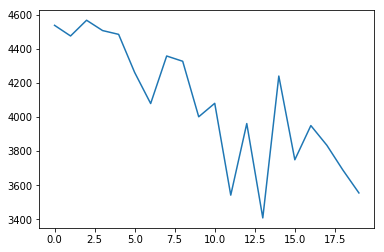

In [8]:
plt.plot(loss_values)
plt.show()

In [10]:
torch.save(model, outpath)

/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Seq2One. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Load Model

In [11]:
model = torch.load(outpath)

In [12]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("---")
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
embed.weight 	 torch.Size([86080, 50])
lstm.weight_ih_l0 	 torch.Size([4096, 50])
lstm.weight_hh_l0 	 torch.Size([4096, 1024])
lstm.bias_ih_l0 	 torch.Size([4096])
lstm.bias_hh_l0 	 torch.Size([4096])
lstm.weight_ih_l0_reverse 	 torch.Size([4096, 50])
lstm.weight_hh_l0_reverse 	 torch.Size([4096, 1024])
lstm.bias_ih_l0_reverse 	 torch.Size([4096])
lstm.bias_hh_l0_reverse 	 torch.Size([4096])
lstm.weight_ih_l1 	 torch.Size([4096, 2048])
lstm.weight_hh_l1 	 torch.Size([4096, 1024])
lstm.bias_ih_l1 	 torch.Size([4096])
lstm.bias_hh_l1 	 torch.Size([4096])
lstm.weight_ih_l1_reverse 	 torch.Size([4096, 2048])
lstm.weight_hh_l1_reverse 	 torch.Size([4096, 1024])
lstm.bias_ih_l1_reverse 	 torch.Size([4096])
lstm.bias_hh_l1_reverse 	 torch.Size([4096])
attention.v 	 torch.Size([1024])
attention.attn.weight 	 torch.Size([1024, 4096])
attention.attn.bias 	 torch.Size([1024])
fc.weight 	 torch.Size([3, 2048])
fc.bias 	 torch.Size([3])
---
Optimizer's state_dict:
state 	 {13964

Mean accuracy: 61.43387862137862
Mean accuracy: 6.096104366442224


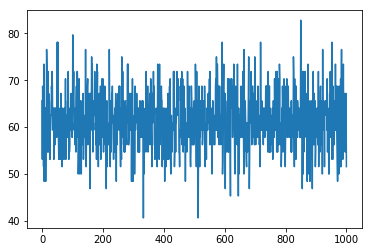

Mean accuracy: 58.71316183816184
Mean accuracy: 6.758186568495104


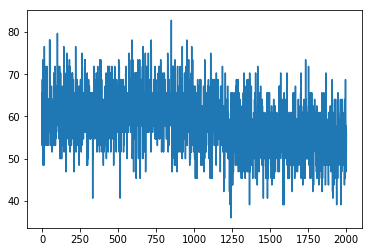

In [15]:
all_acc = []

for iterator in [train_iterator, test_iterator]:
    for batch_idx, batch in enumerate(iterator):

        input_data = batch.text.to(device)
        target_data = batch.target.to(device)
        target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))

        output = model(input_data)

        max_output = torch.argmax(output, dim=1)
        actual_output = target_data_one_hot.argmax(dim=1)

        n_correct = (max_output == actual_output).sum()
        n_total = batch.batch_size
        test_acc = 100. * n_correct/n_total

        # print("test accuracy - %f" % test_acc)
        all_acc.append(test_acc.item())

        if batch_idx == 1000:
            break
    
    print(f"Mean accuracy: {np.mean(all_acc)}")
    print(f"Mean accuracy: {np.std(all_acc)}")
    plt.plot(all_acc)
    plt.show()